#Install Dependencies & Mount Google Drive

In [ ]:
# Install Required Libraries
!pip install pandas torch transformers scikit-learn numpy matplotlib seaborn imbalanced-learn openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries
- Set Random Seed for Reproducibility
- Define Custom Dataset Class

In [ ]:
# Import Libraries
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from tqdm import tqdm
import torch.nn as nn

# Set Random Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset Class
class ERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float)
        }

#Load Evening Dataset with 5 Emotion Regulation (ER) Categories, plus 'None' label (excluding Adaptive/Maladaptive) - 6 Labels
- Process Labels (Multi-Label Binarization)
- Train-Test Split
- Load Tokenizer & Create DataLoaders

In [ ]:
# Load Dataset
file_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/EveningDataset500.xlsx"
df = pd.read_excel(file_path)

# Remove rows where 'text_ner' is missing or blank
df = df.dropna(subset=['text_ner'])
df = df[df['text_ner'].str.strip() != '']  # Ensure no blank texts

# Assign "None" label to missing 'final_label' values
df['final_label'] = df['final_label'].fillna("None")

# Clean the labels by stripping spaces and correcting typos
df['final_label'] = df['final_label'].apply(lambda x: [label.strip() for label in x.split(", ")])  # Remove spaces and split labels
df['final_label'] = df['final_label'].apply(lambda x: [label.replace('Situation Modificaton', 'Situation Modification') for label in x])  # Correct typo

# Ensure "None" is assigned to empty labels
df['final_label'] = df['final_label'].apply(lambda x: x if x else ['None'])

# Convert labels to MultiLabel Format using the cleaned 'final_label'
mlb = MultiLabelBinarizer()
df['er_labels'] = df['final_label']  # Use cleaned labels
er_labels = mlb.fit_transform(df['er_labels'])
all_labels = list(mlb.classes_)  # This now includes "None"

# Train-Test Split (Stratified for Balance)
X_train, X_test, y_train, y_test = train_test_split(
    df['text_ner'], er_labels, test_size=0.3, random_state=42, stratify=None
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Hyperparameters
max_length = 128
batch_size = 16

# Create DataLoader
train_dataset = ERDataset(X_train.tolist(), y_train, tokenizer, max_length)
test_dataset = ERDataset(X_test.tolist(), y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(all_labels)

['Attentional Deployment', 'Cognitive Change', 'None', 'Response Modulation', 'Situation Modification', 'Situation Selection']


#Load BERT Model for Multi-Label Classification
- Define Loss Function with Class Weights
- Define Optimizer & Scheduler

In [ ]:
# Load BERT Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=er_labels.shape[1],
    problem_type="multi_label_classification"
)
model = model.to(device)

# Loss Function with Class Weights
class_counts = np.sum(y_train, axis=0)
pos_weights = torch.tensor((len(y_train) - class_counts) / class_counts, dtype=torch.float).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# Optimizer and Scheduler
from torch.optim import AdamW
epochs = 10
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Save paths of Best model and Best tokenizer

In [ ]:
# Save Paths For Future Use like for Prediction
model_save_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/evening_bert_model_6classes.pth"
tokenizer_save_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/evening_bert_tokenizer_6classes"


#Define Training Function
- Define Evaluation Function
- Training Loop & Save Best Model

In [ ]:
# Training Function
def train_model(model, data_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation Function
def evaluate_model(model, data_loader, device, threshold=0.5):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.sigmoid(logits).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    return (np.array(predictions) > threshold).astype(int), np.array(true_labels)

# Training Loop
best_f1 = 0
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_model(model, train_loader, optimizer, loss_fn, scheduler, device)
    print(f"Train Loss: {train_loss:.4f}")
    predictions, true_labels = evaluate_model(model, test_loader, device)
    f1 = f1_score(true_labels, predictions, average="macro")
    print(f"Validation F1 Score: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), model_save_path)
        tokenizer.save_pretrained(tokenizer_save_path)
        print(f"Model and tokenizer saved at {model_save_path}")

Epoch 1/10


100%|██████████| 22/22 [00:09<00:00,  2.38it/s]


Train Loss: 1.1493
Validation F1 Score: 0.2503
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/evening_bert_model_6classes.pth
Epoch 2/10


100%|██████████| 22/22 [00:07<00:00,  3.14it/s]


Train Loss: 1.1268
Validation F1 Score: 0.3516
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/evening_bert_model_6classes.pth
Epoch 3/10


100%|██████████| 22/22 [00:07<00:00,  3.13it/s]


Train Loss: 0.9191
Validation F1 Score: 0.3859
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/evening_bert_model_6classes.pth
Epoch 4/10


100%|██████████| 22/22 [00:06<00:00,  3.17it/s]


Train Loss: 0.6082
Validation F1 Score: 0.3761
Epoch 5/10


100%|██████████| 22/22 [00:07<00:00,  3.08it/s]


Train Loss: 0.3902
Validation F1 Score: 0.3422
Epoch 6/10


100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


Train Loss: 0.2700
Validation F1 Score: 0.2960
Epoch 7/10


100%|██████████| 22/22 [00:07<00:00,  3.11it/s]


Train Loss: 0.2137
Validation F1 Score: 0.3615
Epoch 8/10


100%|██████████| 22/22 [00:07<00:00,  3.08it/s]


Train Loss: 0.1644
Validation F1 Score: 0.2855
Epoch 9/10


100%|██████████| 22/22 [00:07<00:00,  3.04it/s]


Train Loss: 0.1364
Validation F1 Score: 0.2922
Epoch 10/10


100%|██████████| 22/22 [00:07<00:00,  3.04it/s]


Train Loss: 0.1263
Validation F1 Score: 0.2459


#Load Best Model & Final Evaluation

In [ ]:
# Load Model for Final Evaluation on Test Set
model.load_state_dict(torch.load(model_save_path, map_location=device))
tokenizer = BertTokenizer.from_pretrained(tokenizer_save_path)
model.to(device)
model.eval()
predictions, true_labels = evaluate_model(model, test_loader, device)
print("Final Evaluation on Test Set")
print(classification_report(true_labels, predictions, target_names=all_labels, zero_division=1))

Final Evaluation on Test Set
                        precision    recall  f1-score   support

Attentional Deployment       0.89      0.95      0.92       131
      Cognitive Change       0.41      0.60      0.49        15
                  None       0.38      0.60      0.46        10
   Response Modulation       0.21      0.60      0.32         5
Situation Modification       0.09      0.29      0.13         7
   Situation Selection       1.00      0.00      0.00         2

             micro avg       0.67      0.85      0.75       170
             macro avg       0.50      0.51      0.39       170
          weighted avg       0.77      0.85      0.79       170
           samples avg       0.80      0.87      0.80       170



#Classification Report Using HeatMap

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


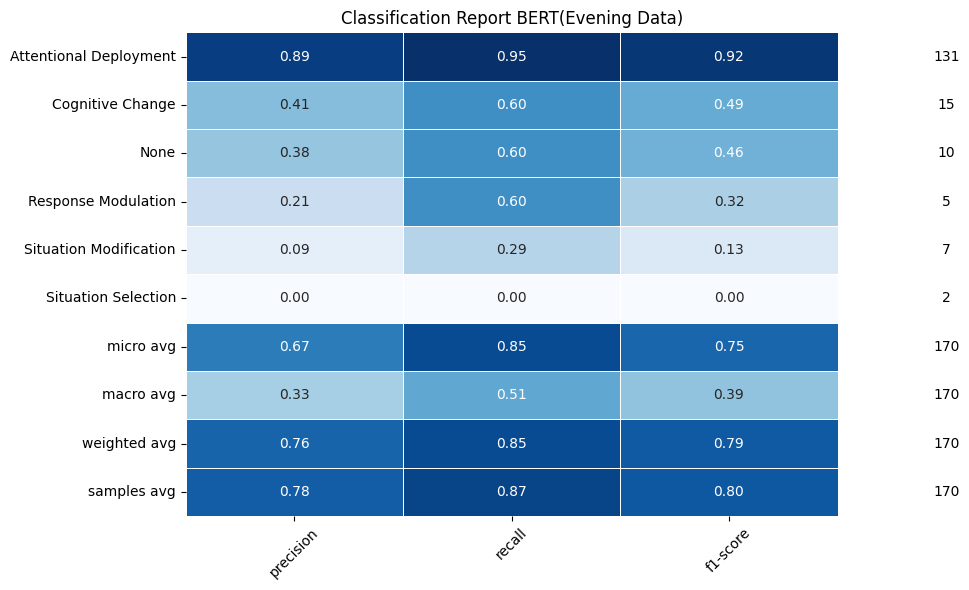

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report_dict = classification_report(true_labels, predictions, target_names=mlb.classes_, output_dict=True)

# Convert to a DataFrame
df_report = pd.DataFrame(report_dict).T

# Separate the metrics and support
df_metrics = df_report.drop(columns=['support'])
df_support = df_report['support']

# Plot heatmap for metrics
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, cbar=False)

# Add support count as text annotations
for i, support in enumerate(df_support):
    plt.text(len(df_metrics.columns) + 0.5, i + 0.5, f"{int(support)}", ha='center', va='center')

plt.title("Classification Report BERT(Evening Data)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/classification_report_heatmap_bertevening_7classes.png")
plt.show()